<a href="https://colab.research.google.com/github/oluwatobybabs/Phishing-emails-Detection-/blob/main/phishing_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MLP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from IPython.display import Markdown, display
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
import warnings

warnings.filterwarnings(action='ignore')

In [ ]:
data=pd.read_csv("/content/sample_data/phishing_hakm_daktakset.1csv.csv",encoding="latin")
data

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,phishing,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
20150,4879,phishing,Subject: get your hand clock repliacs todday c...,1
20151,1735,ham,Subject: txu noms . for 10 / 3 / 2000\r\nattac...,0
20152,3000,ham,Subject: re : nom / actual flow for april 4 th...,0
20153,1989,ham,Subject: re : personal information needs to be...,0


In [ ]:
data.columns

data=data.drop(columns=["Unnamed: 0","label_num"])

data=data.rename(
{
    "label":"Category",
    "text":"Message"
},
    axis=1
)

In [ ]:
for i, row in data.iterrows():
    Message = row['Message'].replace('Subject', '').replace('ect', '').replace('corp', '').replace('enron', '').replace('nbsp', '')
    data.at[i, 'Message'] = Message
data.head()
data.isnull().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20155 entries, 0 to 20154
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  20155 non-null  object
 1   Message   20155 non-null  object
dtypes: object(2)
memory usage: 315.0+ KB


In [ ]:
data["Message Length"]=data["Message"].apply(len)
# fig=plt.figure(figsize=(12,8))
# sns.histplot(
#     x=data["Message Length"],
#     hue=data["Category"]
# )
# plt.title("ham & phishing messege length comparision")
# plt.show()

In [ ]:
ham_desc=data[data["Category"]=="ham"]["Message Length"].describe()
phishing_desc=data[data["Category"]=="phishing"]["Message Length"].describe()

Ham Messege Length Description:
 count    15106.000000
mean      1048.745598
std       1257.199822
min          1.000000
25%        284.250000
50%        711.500000
75%       1426.000000
max      32221.000000
Name: Message Length, dtype: float64
************************************
phishing Message Length Description:
 count     5049.000000
mean      1183.323628
std       1742.747628
min          4.000000
25%        267.000000
50%        580.000000
75%       1258.000000
max      21982.000000
Name: Message Length, dtype: float64


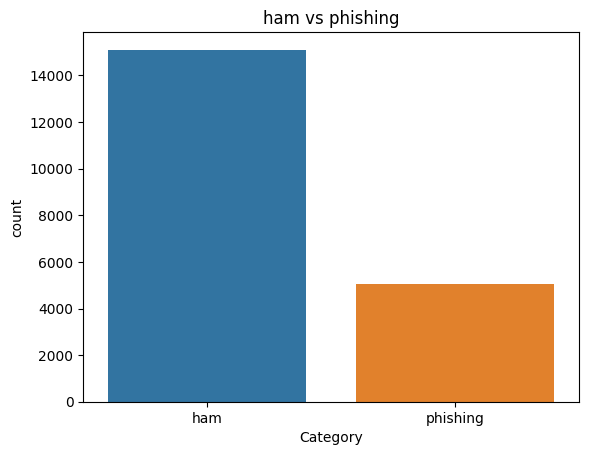

In [ ]:
print("Ham Messege Length Description:\n",ham_desc)
print("************************************")
print("phishing Message Length Description:\n",phishing_desc)
data.describe(include="all")
data["Category"].value_counts()
sns.countplot(
    data=data,
    x="Category"
)
plt.title("ham vs phishing")
plt.show()

In [ ]:
ham_count=data["Category"].value_counts()[0]
phishing_count=data["Category"].value_counts()[1]

total_count=data.shape[0]

print("Ham contains:{:.2f}% of total data.".format(ham_count/total_count*100))
print("phishing contains:{:.2f}% of total data.".format(phishing_count/total_count*100))


Ham contains:74.95% of total data.
phishing contains:25.05% of total data.


In [ ]:
minority_len=len(data[data["Category"]=="phishing"])
majority_len=len(data[data["Category"]=="ham"])

#store the indices of majority and minority class
minority_indices=data[data["Category"]=="phishing"].index
majority_indices=data[data["Category"]=="ham"].index

#generate new majority indices from the total majority_indices
#with size equal to minority class length so we obtain equivalent number of indices length
random_majority_indices=np.random.choice(
    majority_indices,
    size=minority_len,
    replace=False
)

In [ ]:
#concatenate the two indices to obtain indices of new dataframe
undersampled_indices=np.concatenate([minority_indices,random_majority_indices])

#create df using new indices
df=data.loc[undersampled_indices]

#shuffle the sample
df=df.sample(frac=1)

#reset the index as its all mixed
df=df.reset_index()

df

,index,Category,Message,Message Length
0,19806,ham,: calpine - 1465\r\nricky sent the nom over ea...,92
1,10013,ham,: re : defs 2001\r\ndaren :\r\ni needed the de...,802
2,416,ham,: eastrans nomination change effive 4 / 28 / 0...,315
3,19276,phishing,eBay Security Validation - Update Account Noti...,817
4,12897,phishing,: vic . odin n ^ ow\r\nberne hotbox carnal bri...,388
...,...,...,...,...
10093,4776,phishing,: here u can buy soft . ware at che - ap jessa...,1390
10094,13042,phishing,": re : aekdju , the cat raised\r\nour us licen...",557
10095,2419,ham,: christmas lunch - texas logistics\r\nthe tex...,545
10096,18447,ham,"Dear California Bank & Trust member, For secur...",763


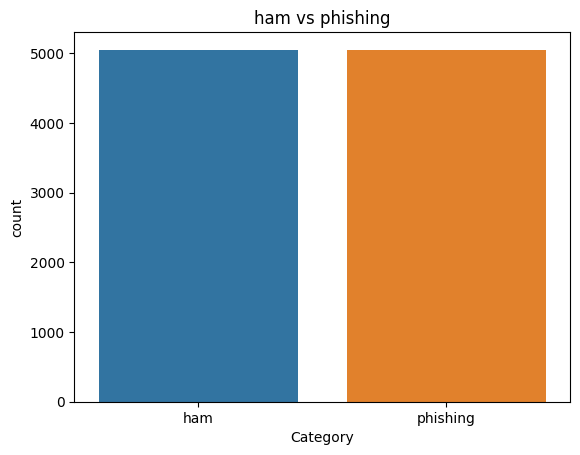

,Category,Message,Message Length,Label
0,ham,: calpine - 1465\r\nricky sent the nom over ea...,92,0
1,ham,: re : defs 2001\r\ndaren :\r\ni needed the de...,802,0
2,ham,: eastrans nomination change effive 4 / 28 / 0...,315,0
3,phishing,eBay Security Validation - Update Account Noti...,817,1
4,phishing,: vic . odin n ^ ow\r\nberne hotbox carnal bri...,388,1


In [ ]:
#drop the older index
df=df.drop(
    columns=["index"],
)

df.shape
df["Category"].value_counts()
sns.countplot(
    data=df,
    x="Category"
)
plt.title("ham vs phishing")
plt.show()
df.head()
df["Label"]=df["Category"].map(
    {
        "ham":0,
        "phishing":1
    }
)
df.head()


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer=PorterStemmer()
#declare empty list to store tokenized message
corpus=[]

#iterate through the df["Message"]
for message in df["Message"]:

    #replace every special characters, numbers etc.. with whitespace of message
    #It will help retain only letter/alphabets
    message=re.sub("[^a-zA-Z]"," ",message)

    #convert every letters to its lowercase
    message=message.lower()

    #split the word into individual word list
    message=message.split()

    #perform stemming using PorterStemmer for all non-english-stopwords
    message=[stemmer.stem(words)
            for words in message
             if words not in set(stopwords.words("english"))
            ]
    #join the word lists with the whitespace
    message=" ".join(message)

    #append the message in corpus list
    corpus.append(message)

vocab_size=10000


In [ ]:
oneHot_doc=[one_hot(words,n=vocab_size)
           for words in corpus
           ]


sentence_len=200
embedded_doc=pad_sequences(
    oneHot_doc,
    maxlen=sentence_len,
    padding="pre"
)
extract_features=pd.DataFrame(
    data=embedded_doc
)
target=df["Label"]
df_final=pd.concat([extract_features,target],axis=1)
df_final.head()
X=df_final.drop("Label",axis=1)
y=df_final["Label"]
from sklearn.model_selection import train_test_split



X_trainval,X_test,y_trainval,y_test=train_test_split(
    X,
    y,
    random_state=42,
    test_size=0.15
)

X_train,X_val,y_train,y_val=train_test_split(
    X_trainval,
    y_trainval,
    random_state=42,
    test_size=0.15
)



In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential

model_lstm=Sequential()
feature_num=100
model_lstm.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=feature_num,
        input_length=sentence_len
    )
)
model_lstm.add(
    LSTM(
    units=128
    )
)

model_lstm.add(
    Dense(
        units=1,
        activation="sigmoid"
    )
)
from tensorflow.keras.optimizers import Adam
model_lstm.compile(
    optimizer=Adam(
    learning_rate=0.001
    ),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
model_lstm.fit(
    X_train,
    y_train,
    validation_data=(
        X_val,
        y_val
    ),
    epochs=10
)

y_pred=model_lstm.predict(X_test)
y_pred=(y_pred>0.5)


Epoch 1/10
228/228 [==============================] - 54s 205ms/step - loss: 0.2361 - accuracy: 0.9082 - val_loss: 0.1330 - val_accuracy: 0.9542
Epoch 2/10
228/228 [==============================] - 33s 145ms/step - loss: 0.0799 - accuracy: 0.9729 - val_loss: 0.1010 - val_accuracy: 0.9666
Epoch 3/10
228/228 [==============================] - 23s 102ms/step - loss: 0.0567 - accuracy: 0.9814 - val_loss: 0.1050 - val_accuracy: 0.9573
Epoch 4/10
228/228 [==============================] - 20s 90ms/step - loss: 0.0521 - accuracy: 0.9808 - val_loss: 0.0932 - val_accuracy: 0.9689
Epoch 5/10
228/228 [==============================] - 17s 75ms/step - loss: 0.0456 - accuracy: 0.9823 - val_loss: 0.0955 - val_accuracy: 0.9682
Epoch 6/10
228/228 [==============================] - 11s 49ms/step - loss: 0.0412 - accuracy: 0.9842 - val_loss: 0.0811 - val_accuracy: 0.9666
Epoch 7/10
228/228 [==============================] - 10s 44ms/step - loss: 0.0521 - accuracy: 0.9801 - val_loss: 0.0815 - val_accura

In [ ]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Print the accuracy and classification report on the test data
print(f'## Accuracy: {round(accuracy_score(y_test, y_pred), 3)*100}%\n')
print(classification_report(y_test, y_pred))

## Accuracy: 96.8%

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       744
           1       0.95      0.99      0.97       771

    accuracy                           0.97      1515
   macro avg       0.97      0.97      0.97      1515
weighted avg       0.97      0.97      0.97      1515



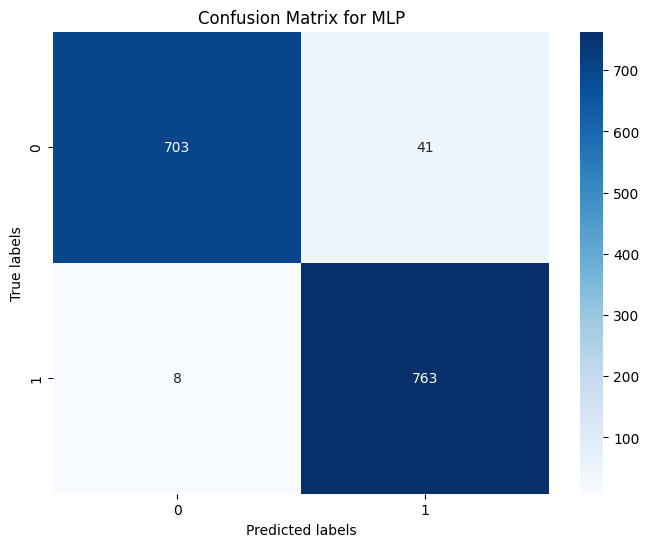

## Accuracy: 96.8%

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       744
           1       0.95      0.99      0.97       771

    accuracy                           0.97      1515
   macro avg       0.97      0.97      0.97      1515
weighted avg       0.97      0.97      0.97      1515



In [ ]:
# Print the accuracy and classification report on the test data
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for MLP")
plt.show()


print(f'## Accuracy: {round(accuracy_score(y_test, y_pred), 3)*100}%\n')
print(classification_report(y_test, y_pred))


In [ ]:
df=pd.read_csv("/content/sample_data/phishing_hakm_daktakset.1csv.csv", encoding='ISO-8859-1')

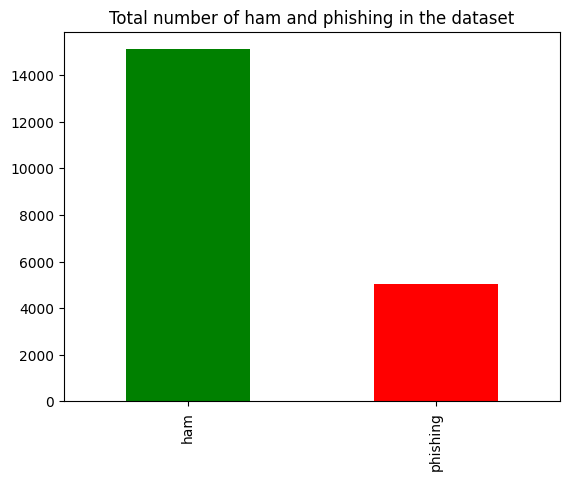

Before cleaning:


":  methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to refl daily\r\nactivity you can obtain from gas control .\r\nthis change is needed asap for economics purposes ."

In [ ]:
for i, row in df.iterrows():
    text = row['text'].replace('Subject', '').replace('ect', '').replace('corp', '').replace('enron', '').replace('nbsp', '')
    df.at[i, 'text'] = text

phishing_df = df.loc[df['label'] == 'phishing']
phishing_text = ' '.join(phishing_df['text'])

ham_df = df.loc[df['label'] == 'ham']
ham_text = ' '.join(ham_df['text'])

import pandas as pd
df['label'].value_counts().plot.bar(color = ["g","r"])
plt.title('Total number of ham and phishing in the dataset')
plt.show()
from nltk.tokenize import RegexpTokenizer

def clean_str(string, reg = RegexpTokenizer(r'[a-z]+')):
    # Clean a string with RegexpTokenizer
    string = string.lower()
    tokens = reg.tokenize(string)
    return " ".join(tokens)

print('Before cleaning:')
df['text'][0]

In [ ]:
print('After cleaning:')
clean_str(df['text'][0])


After cleaning:


'methanol meter this is a follow up to the note i gave you on monday preliminary flow data provided by daren please override pop s daily volume presently zero to refl daily activity you can obtain from gas control this change is needed asap for economics purposes'

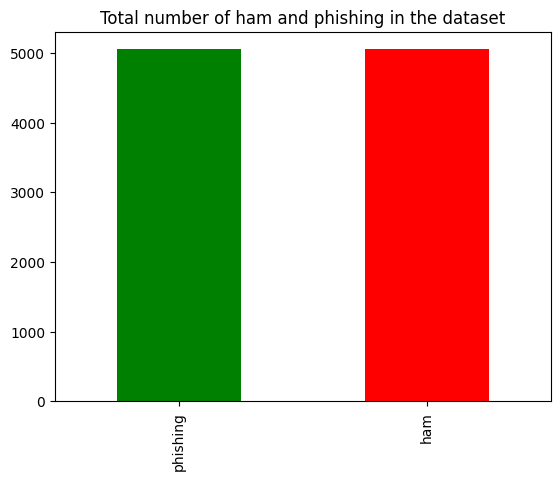

In [ ]:
# Create a new column with the cleaned messages
df['text_clean'] = df['text'].apply(lambda string: clean_str(string))

# Split the dataset into train and test sets
from sklearn.utils import resample

# Separate the majority and minority classes
phishing_df = df.loc[df['label'] == 'phishing']
ham_df = df.loc[df['label'] == 'ham']

# Undersample the majority class
ham_df_undersampled = resample(ham_df,
                               replace=False,    # sample without replacement
                               n_samples=len(phishing_df),    # match minority class size
                               random_state=0)   # reproducible results

# Combine the undersampled majority class with the minority class
balanced_df = pd.concat([phishing_df, ham_df_undersampled])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=0)

balanced_df['label'].value_counts().plot.bar(color = ["g","r"])
plt.title('Total number of ham and phishing in the dataset')
plt.show()

# Split the balanced dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(balanced_df['text_clean'], balanced_df['label'], test_size=0.2, random_state=0)


In [ ]:
from sklearn.neural_network import MLPClassifier
# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MLPClassifier(hidden_layer_sizes=[20, 20], learning_rate='adaptive', random_state=8))
])

# Define the hyperparameters for GridSearchCV
# Define the hyperparameters to be tuned
parameters = {
    "vectorizer__ngram_range": [(1,1), (1,2)],
    "classifier__alpha": [0.2, 1, 2, 5, 10],
    "classifier__fit_prior": [True, False]
}
# Fit the model with the best hyperparameters on the train data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=[20, 20],
                               learning_rate='adaptive', random_state=8))])

In [ ]:
# Predict the labels of the test data
y_pred = pipeline.predict(X_test)

X_test

1249       keep up the good work we at home love it at ken
7158     hm elblo dear home owner we hajv e bee n nboti...
1411     acrobat pro xp pro opt in email special offer ...
254      sec information earnings restatement today we ...
10530                 guaranteed satisfaction great prices
                               ...                        
16145    focus on positive asps of your life hi varou s...
4785     something unusual just her size city ease doct...
19446    re ami chokshi resigns i have an exit intervie...
10682    food for thoughts join now take a free tour cl...
20079    natural gas nomination methanol company nomina...
Name: text_clean, Length: 2020, dtype: object

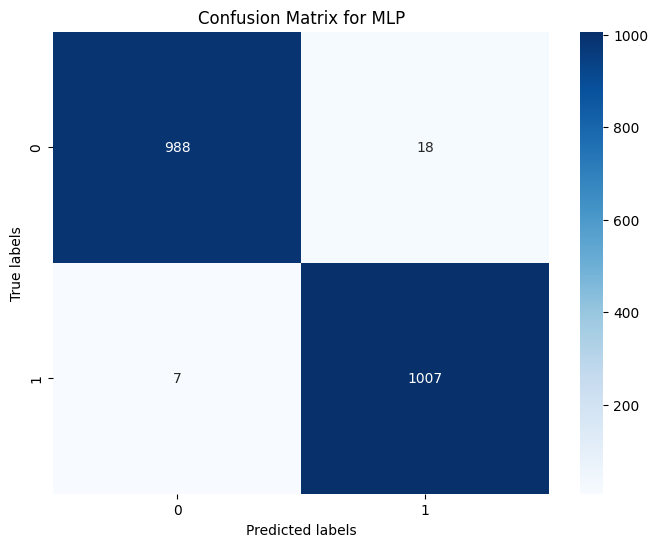

## Accuracy: 98.8%

              precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1006
    phishing       0.98      0.99      0.99      1014

    accuracy                           0.99      2020
   macro avg       0.99      0.99      0.99      2020
weighted avg       0.99      0.99      0.99      2020



In [ ]:
# Print the accuracy and classification report on the test data
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred, labels=['ham', 'phishing'])

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for MLP")
plt.show()


print(f'## Accuracy: {round(accuracy_score(y_test, y_pred), 3)*100}%\n')
print(classification_report(y_test, y_pred))


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def classify_message(model, message):
    # Split message into individual sentences
    sentences = nltk.sent_tokenize(message)

    # Iterate over each sentence
    for sentence in sentences:
        # Remove special characters
        words = re.sub("[^a-zA-Z]", " ", sentence)

        # Tokenize words and remove stopwords
        if words not in set(stopwords.words('english')):
            word = nltk.word_tokenize(words)
            word = " ".join(word)

    # Encode text using one_hot
    oneHot = [one_hot(word, n=vocab_size)]

    # Pad sequences to match model input shape
    text = pad_sequences(oneHot, maxlen=sentence_len, padding="pre")

    # Predict text label using model
    predict = model.predict(text)

    return predict

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)
model.save('phishing_lstm.h5')

NameError: ignored

#**Building Flask API**

In [ ]:
!pip install pyngrok
!pip install flask_cors
!pip install flask_ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=89935b4903b5a0e1d9c76a501f72a1cb03a0c21c719d487470c169a4460b66cc
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import getpass

from pyngrok import ngrok, conf

print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = getpass.getpass()

# Open a TCP ngrok tunnel to the SSH server
connection_string = ngrok.connect(5000).public_url

ssh_url, port = connection_string.strip("tcp://").split(":")
print(f" * ngrok tunnel available, access with `ssh root@{ssh_url} -p{port}`")

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········


ERROR:pyngrok.process.ngrok:t=2023-06-22T18:27:56+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=0577b64c3958 err="authentication failed: Your account is limited to 1 simultaneous ngrok agent session.\nYou can run multiple tunnels on a single agent session using a configuration file.\nTo learn more, see https://ngrok.com/docs/ngrok-agent/config/\n\nActive ngrok agent sessions in region 'us':\n  - ts_2RZDllvhXKW8YbIZCDNbkzh42ok (35.226.194.35)\r\n\r\nERR_NGROK_108\r\n"


PyngrokNgrokError: ignored

In [ ]:
import keras

In [ ]:
mlp_model = pipeline

lstm_model = model_lstm

In [ ]:
from flask_cors import CORS, cross_origin
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok
from importlib.util import module_for_loader
from flask import Flask, request
from flask_cors import CORS, cross_origin
from tensorflow import keras
import pickle
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

app = Flask(__name__)
cors = CORS(app, support_credentials=True)
run_with_ngrok(app)
app.config['CORS_HEADERS'] = 'Content-Type'

# Define function to classify message using model
def classify_message(model, message):
    # Split message into individual sentences
    sentences = nltk.sent_tokenize(message)

    # Iterate over each sentence
    for sentence in sentences:
        # Remove special characters
        words = re.sub("[^a-zA-Z]", " ", sentence)

        # Tokenize words and remove stopwords
        if words not in set(stopwords.words('english')):
            word = nltk.word_tokenize(words)
            word = " ".join(word)

    # Encode text using one_hot
    oneHot = [one_hot(word, n=vocab_size)]

    # Pad sequences to match model input shape
    text = pad_sequences(oneHot, maxlen=sentence_len, padding="pre")

    # Predict text label using model
    predict = model.predict(text)

    return predict

@app.route("/", methods=['POST', 'OPTIONS'])
@cross_origin(supports_credentials=True)
def predict():
    if request.method == 'OPTIONS':
        response = jsonify()
        response.headers.add('Access-Control-Allow-Origin', '*')
        response.headers.add('Access-Control-Allow-Headers', '*')
        response.headers.add('Access-Control-Allow-Methods', '*')
        return response

    # Parse request data
    request_data = request.get_json(force=True)
    mail = request_data['mail']

    # Predict label and probability using LSTM model
    lstm_prob = classify_message(lstm_model, mail) * 100
    lstm_prediction = "ham"
    if lstm_prob > 0.5:
        lstm_prediction = "phishing"

    # Predict label and probability using MLP model
    [mlp_prediction] = mlp_model.predict([mail])
    if mlp_prediction == 'spam':
        mlp_prediction == 'phishing'
    mlp_prob = max(mlp_model.predict_proba([mail])[0]) * 100

    prob = "MLP prediction: {} ({}%)\nLSTM prediction: {} ({}%)".format(mlp_prediction, mlp_prob, lstm_prediction, lstm_prob)

    # Add CORS header to response
    response = jsonify(prob)
    response.headers.add('Access-Control-Allow-Origin', 'chrome-extension://djlihomfnedgkjjfdpbghpddllgncmmp')

    # Return predictions in formatted string
    return response


if __name__ == '__main__':
  app.run()
